# Exercise06: Pandas and Plotting

Required packages:
* pandas
* seaborn
* scipy

Objectives:
* Get experience working with pandas data frames
* Handling missing data
* Plotting data using seaborn
* Performing a quick statistical test to test a hypothesis

In this exercise I'd like you to work with the data you generated in PointyGame, `treatments.csv`.  We are going to load this data into a Pandas' DataFrame and perform a quick analysis on the data.  If you don't have a `treatments.csv` available, use the one that may be found with this notebook on Google Drive.

In the end, I'd like you to be able to answer the question:  (Given our assumptions), is one of the strategies better at playing PointyGame than the others?

Due: End of the day, Saturday, 13 February.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

## Load the treatments.csv file into a DataFrame

In [2]:
treatments = pd.read_csv("treatments.csv")
treatments.head()

,treatment,replicate,step,creature_x,creature_y,score
0,play_greedily,0,0,4,4,1000
1,play_greedily,0,1,4,3,1140
2,play_greedily,0,2,4,2,1130
3,play_greedily,0,3,4,2,1125
4,play_greedily,0,4,3,2,1215


## Explore the data

+ Describe it
+ What are the columns, data types?
    - Are these nominal, categorical, interval, ratio type(s)?
    - Are these values discrete or continuous?
+ How many entries are there?


In [3]:
treatments.describe()

,replicate,step,creature_x,creature_y,score
count,9090.000000,9090.000000,9090.000000,9090.000000,9090.000000
mean,14.500000,50.000000,4.388229,3.617602,1058.422992
std,8.655918,29.156363,2.664521,2.695105,355.054123
min,0.000000,0.000000,0.000000,0.000000,15.000000
25%,7.000000,25.000000,2.000000,1.000000,831.250000
50%,14.500000,50.000000,4.000000,3.000000,1065.000000
75%,22.000000,75.000000,7.000000,6.000000,1275.000000
max,29.000000,100.000000,8.000000,8.000000,2250.000000


In [4]:
treatments.dtypes

treatment     object
replicate      int64
step           int64
creature_x     int64
creature_y     int64
score          int64
dtype: object

In [5]:
treatments.shape

(9090, 6)

From the head, desribe and dtypes, we can infer that
Only score is a continuous variable.
Replicate and step are ordinal variables
treatment, creature_x and creature_y are categorical variables 

## Let's clean (pad) if needed

Some games didn't end with all 100 rounds being played.  Each replicate should have 101 entries, including the value before a single round of the game was played.

I'd like you to make sure that each replicate has all 101 entries.  Please pad your dataframe accordingly.  (For the sake of simplicity, let's just pad these missing rounds with 0s for the score and NaNs for the locations of the creature.)

You can do this any way you'd like: with loops, or [more advanced techniques](https://stackoverflow.com/questions/55355435/pandas-how-to-pad-value-for-every-row-that-missing-years) that use multiindexes.

In [6]:
len(treatments.groupby(["treatment","replicate"])["score"].count().reset_index()["score"] == 101)

90

In [7]:
treatments.isnull().sum()

treatment     0
replicate     0
step          0
creature_x    0
creature_y    0
score         0
dtype: int64

## Make a pivot tables

I'd like to know the min, max, and mean scores for each replicate, grouped by treatment.

I'd also like to know the min, max, and mean scores for each treatment overall.

Finally, I'd like you to give me the min, max, and mean scores for the last round (100) of each treatment.

In [8]:
pd.pivot_table(treatments.reset_index(),values="score",index=["treatment","replicate"],aggfunc=[np.min,np.max,np.mean])

amin  amax         mean
                        score score        score
treatment     replicate                         
play_greedily 0          1000  1925  1600.990099
              1           685  1235  1013.712871
              2          1000  1850  1632.623762
              3          1000  1570  1324.752475
              4           990  1815  1384.801980
...                       ...   ...          ...
play_randomly 25          205  1085   548.762376
              26           30  1030   466.237624
              27          400  1025   684.455446
              28          335  1045   710.891089
              29          540  1000   714.257426

[90 rows x 3 columns]

In [9]:
pd.pivot_table(treatments.reset_index(),values="score",index=["treatment"],aggfunc=[np.min,np.max,np.mean])

,amin,amax,mean
,score,score,score
treatment,,,
play_greedily,385,2250,1253.562706
play_greedy_with_random,455,2015,1185.722772
play_randomly,15,1195,735.983498


In [10]:
pd.pivot_table(treatments.reset_index().groupby("treatment").tail(100).reset_index(),values="score",index=["treatment"],aggfunc=[np.min,np.max,np.mean])

,amin,amax,mean
,score,score,score
treatment,,,
play_greedily,650,1290,1012.5
play_greedy_with_random,945,1725,1458.5
play_randomly,540,990,711.4


## Plotting

1. I'd like to see the distribution of final scores for each replicate grouped by treatment.  Use a violin plot.  Are there any qualatative differences between the distributions of final scores among treatments?

2. I'd like you to plot a heatmap for each treatment where the value of each cell in the heatmap indicates how many round(s) the creature spent in each cell in the grid.  Are there any qualatative differences among the three strategies?

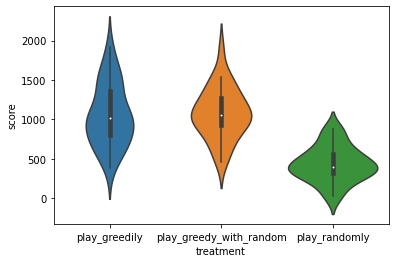

In [11]:
sns.violinplot(data=treatments.groupby(["treatment","replicate"]).last().reset_index(),x="treatment",y="score")
plt.show()

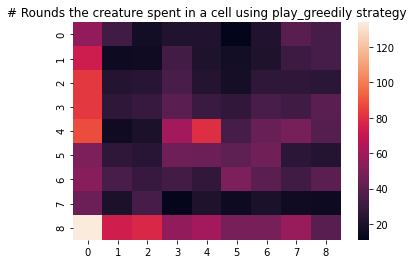

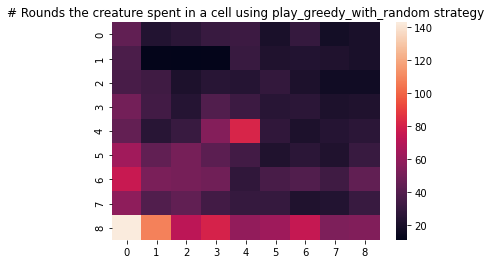

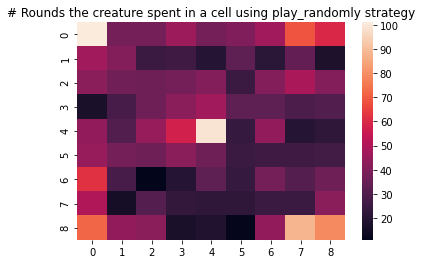

In [12]:
for t in ["play_greedily","play_greedy_with_random","play_randomly"]:
    t1 = treatments[treatments["treatment"] == t].groupby(["creature_x","creature_y"])["step"].count().reset_index()
    arr1 = np.zeros((t1["creature_x"].max()+1,t1["creature_y"].max()+1))
    arr1[t1["creature_x"],t1["creature_y"]] = t1["step"]
    sns.heatmap(arr1)
    plt.title(f"# Rounds the creature spent in a cell using {t} strategy")
    plt.show()

## A quick test

Let's see if there are strategies that play the game "better" than random.  We're going to do a quick test of this hypothesis:

$H_0$: play_greedily and play_greedy_with_random perform just as well as play_randomly

$H_{a1}$: play_greedily results in higher scores than play_random

$H_{a2}$: play_greedy_with_random results in higher scores than play_random

$H_{a3}$: both play_greedily and play_reedy_with_random result in higher scores than play randomly

To do this, we will perform two [one-sided Mann-Whitney U-Tests](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) on the final scores of the game for each treatment.  (We're using a MWU test because I don't want to make any assumptions about the distribution of the final scores.  Remember: distributions are the result of physical processes.  Here I want to not make any assumptions about those, so we're going to use this non-parametric statistical test.)

* Run a U-Test of play_random final scores against play_greedily final scores.  Make this a one-sided test to see if play_greedily has a greater medial location.

* Run a U-Test of play_random final scores against play_greedy_with_random final scores.  Make this a one-sided test to see if play_greedily has a greater medial location.



In [13]:
mannwhitneyu(treatments[treatments["treatment"] == "play_randomly"].groupby(["treatment","replicate"]).last()["score"],
             treatments[treatments["treatment"] == "play_greedily"].groupby(["treatment","replicate"]).last()["score"],
             alternative = "greater")

MannwhitneyuResult(statistic=61.5, pvalue=0.9999999955887612)

In [14]:
mannwhitneyu(treatments[treatments["treatment"] == "play_randomly"].groupby(["treatment","replicate"]).last()["score"],
             treatments[treatments["treatment"] == "play_greedy_with_random"].groupby(["treatment","replicate"]).last()["score"],
             alternative = "greater")

MannwhitneyuResult(statistic=36.0, pvalue=0.9999999995568752)